In [2]:
import open_clip
import torch
import time
import sys
import matplotlib.pyplot as plt
from torchprofile import profile_macs
from datasets import load_dataset
from torchvision.transforms import v2 as T
from torch.profiler import profile, record_function, ProfilerActivity

sys.path.append('..')
sys.path.append('../..')
from encoders.openclip_encoder import PatchDropout, PatchDropoutFov
from tqdm import tqdm
import seaborn as sns
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

/home/sandeepmukh/DeepUL294Proj/.deepulenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model, prep, _ = open_clip.create_model_and_transforms("ViT-H-14", "laion2b_s32b_b79k")
model = model.visual

Text(0.5, 0, 'Mask ratio')

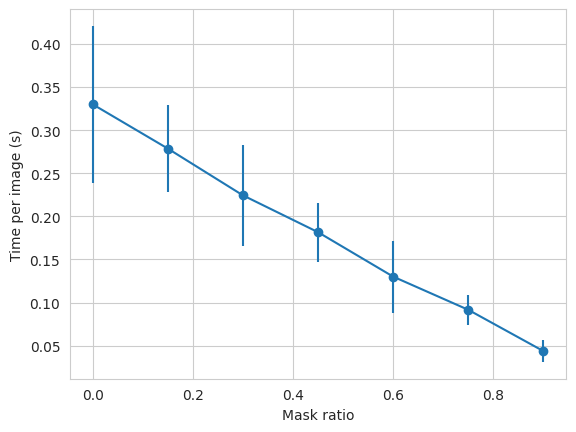

In [36]:
device = 'cuda:4'

def time_inference(model, mask_ratio, n_iter=100):
    model = model.to(device)
    model.eval()
    model.patch_dropout = PatchDropout(mask_ratio)
    inp = torch.zeros(16, 3, 224, 224).to(device)
    with torch.no_grad():
      times = []
      for _ in tqdm(range(n_iter)):
        inp = inp.normal_()
        start = time.time()
        _ = model(inp)
        times.append(time.time() - start)
    return sum(times) / len(times), torch.tensor(times).std().item() / (len(times) ** .5)

# grid sweep over mask ratios
# mask_ratios = [0, .15, .3, .45, .6, .75, .9]
# means, stds = [], []
# for mask_ratio in mask_ratios:
#     mean, std = time_inference(model, mask_ratio)
#     means.append(mean)
#     stds.append(std)

plt.errorbar(mask_ratios, [m  for m in means], yerr=[s*10*1.96 for s in stds], fmt='o-')
plt.ylabel('Time per image (s)')
plt.xlabel('Mask ratio')

In [ ]:
# 4363729968
((16852059696 / 1e9) - (4363729968 / 1e9))/(16852059696 / 1e9)

Text(0.5, 0, 'Mask ratio')

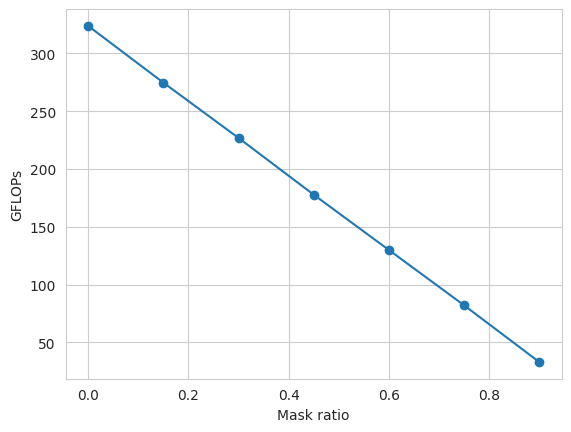

In [37]:
# macs = []
# for mr in mask_ratios:
#   model.patch_dropout = PatchDropout(mr)
#   macs.append(profile_macs(model, torch.randn(1, 3, 224, 224).to(device)));
plt.errorbar(mask_ratios, [2*m/1e9  for m in macs], fmt='o-')
plt.ylabel('GFLOPs')
plt.xlabel('Mask ratio')

In [49]:
with profile(activities=[ProfilerActivity.CUDA],
        profile_memory=True, record_shapes=True) as prof:
    inputs = torch.zeros(16, 3, 224, 224).to(device).normal_()
    model.patch_dropout = PatchDropout(0.75)
    model(inputs)

print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

STAGE:2024-05-09 23:44:57 14269:14269 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-09 23:44:57 14269:14269 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-09 23:44:57 14269:14269 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:938] Warning: Failed to recover relationship between all profiler and kineto events: 1644 vs. 0  reassociated. (function reassociate)


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               [memory]         0.00%       0.000us         0.00%       0.000us       0.000us       0.000us         0.00%       0.000us       0.000us           0 b           0 b          1644  
                                        cudaMemcpyAsync        30.02%       2.934ms        30.0

In [3]:
def patchify(imgs, patch_size):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x, patch_size):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs
  
ds = load_dataset("HuggingFaceM4/COCO")
ds.set_format(type="torch")

/home/sandeepmukh/DeepUL294Proj/.deepulenv/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for HuggingFaceM4/COCO contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/HuggingFaceM4/COCO
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [41]:
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_patches(tensor):
    n_patch = int(tensor.shape[1] ** .5)
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(n_patch, n_patch), axes_pad=0.0)
    tensor = tensor.reshape(n_patch*n_patch, (224*2)//n_patch, (224*2)//n_patch, 3)

    for i, ax in enumerate(grid):
        patch = tensor[i].numpy() 
        ax.imshow(patch)
        ax.axis('off')

    plt.show()

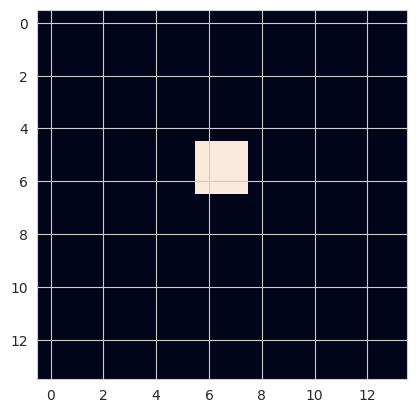

In [5]:
std_dev = .1
num_tokens = 196
token_locs = torch.arange(num_tokens)
distances = ((token_locs // num_tokens**.5) - 5.5)**2 \
                        + ((token_locs % num_tokens**.5) - 6.5)**2

# Calculate probabilities based on normal distribution
probabilities = torch.exp(-distances / (2 * std_dev**2))
# probabilities = 1/(std_dev*(1+distances/std_dev**2))
plt.imshow(probabilities.reshape(14, 14).numpy())

In [6]:
fov = PatchDropoutFov(.75, False)

In [24]:
patches.shape

torch.Size([1, 64, 588])

In [30]:
patches.shape

torch.Size([1, 64, 588])

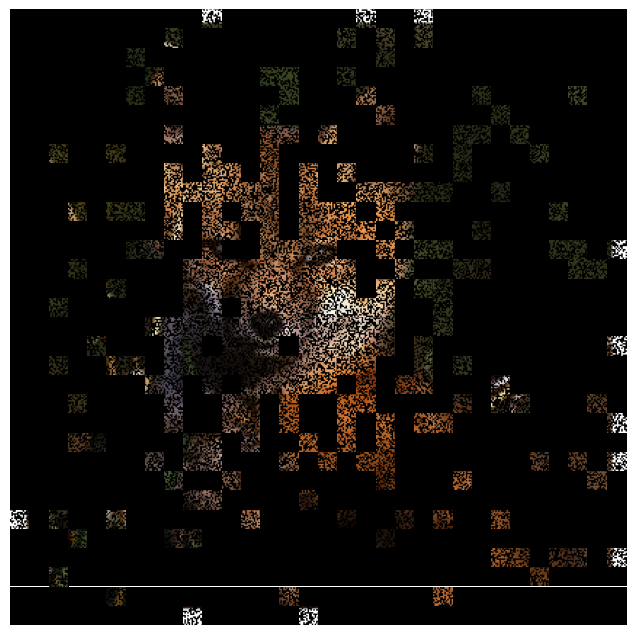

In [44]:
from torchvision.io import read_image
fov = PatchDropoutFov(.75, False)
resize = T.Resize((224*2, 224*2))
img = resize(read_image('fox.png')[None, :3])
patches = patchify(img, 14)
patches, keep = fov(patches, torch.tensor([7.5*2, 7.5*2]), 1, True)
patches = patches.reshape(1, -1, 14, 14, 3)
patches[torch.rand(1, patches.shape[1], 14, 14) < .5, :] = 0
patches = patches.reshape(1, -1, 14*14*3)
blank = patchify(torch.ones_like(img), 14) * 0
blank[:, keep] = patches
plot_patches(blank)
# fov = PatchDropout(.75, False)
# patches = patchify(img, 16)
# patches, keep = fov(patches, True)
# blank = patchify(torch.zeros_like(img), 16)
# blank[:, keep] = patches
# plot_patches(blank)
# plt.imshow(img[0].permute(1, 2, 0))
# plt.axis('off')